# Analysis Trump/Clinton Tweets - 2016

### Objective: Use statistics, some time series and machine learning to characterize 'tweeter speech' from Donald Trump/Hillary Clinton 

Analysis keypoints:
 1. Use tweepy to download the tweets authored by Donald Trump.
 2. Analysis of Hashtag frequency - What can we learn?
 3. Time series analysis - Number of tweets/correlation - Locate peaks
 4. Word histogram - What are the words more frequently used by either candidate? What can we learn?
 5. But... humans are biased, are they not? Can we do better? Use machine learning!
 6. What about unsupervised learning? Does a predictive model make sense?

In [1]:
#Import the data. The tweets were downloaded using Tweepy.
import json, glob
import datetime
import pandas as pd

In [2]:
dt_tweets_json = []
hc_tweets_json = []
for fn in glob.glob('data/*'):
    with open(fn, 'r') as f:
        if 'Clinton' in fn:
            for line in f:
                hc_tweets_json.append(json.loads(line))
        else:
            for line in f:
                dt_tweets_json.append(json.loads(line))

df_dt = pd.DataFrame(dt_tweets_json).drop_duplicates(subset='id_str', keep='last')
df_dt = df_dt.set_index('id_str', inplace=False)
df_hc = pd.DataFrame(hc_tweets_json).drop_duplicates(subset='id_str', keep='last')
df_hc = df_hc.set_index('id_str', inplace=False)

In [3]:
to_datetime = lambda x: datetime.datetime.strptime(x, "%a %b %d %H:%M:%S +0000 %Y")
df_dt['created_at'] = df_dt['created_at'].apply(to_datetime)
df_hc['created_at'] = df_hc['created_at'].apply(to_datetime)

## 2. Temporal analysis - Who tweets the most?

In [4]:
#Extract number of tweets per date, create dictionaries with information.
from collections import Counter

hc_tweets_per_day = Counter([x.date() for x in df_hc.created_at if x.year > 2015])
dt_tweets_per_day = Counter([x.date() for x in df_dt.created_at if x.year > 2015])
hc_tweets_per_day_noRT = Counter([x.date() for x in df_hc[['RT ' not in x for x in df_hc.text.values]].created_at if x.year > 2015])
dt_tweets_per_day_noRT = Counter([x.date() for x in df_dt[['RT ' not in x for x in df_dt.text.values]].created_at if x.year > 2015])
hc_tweets_per_day_only_RT = Counter([x.date() for x in df_hc[['RT ' in x for x in df_hc.text.values]].created_at if x.year > 2015])
dt_tweets_per_day_only_RT = Counter([x.date() for x in df_dt[['RT ' in x for x in df_dt.text.values]].created_at if x.year > 2015])
#dt_tweets_per_day = Counter([x.date() for x in dt_tweets_json if to_datetime(x).year > 2015])

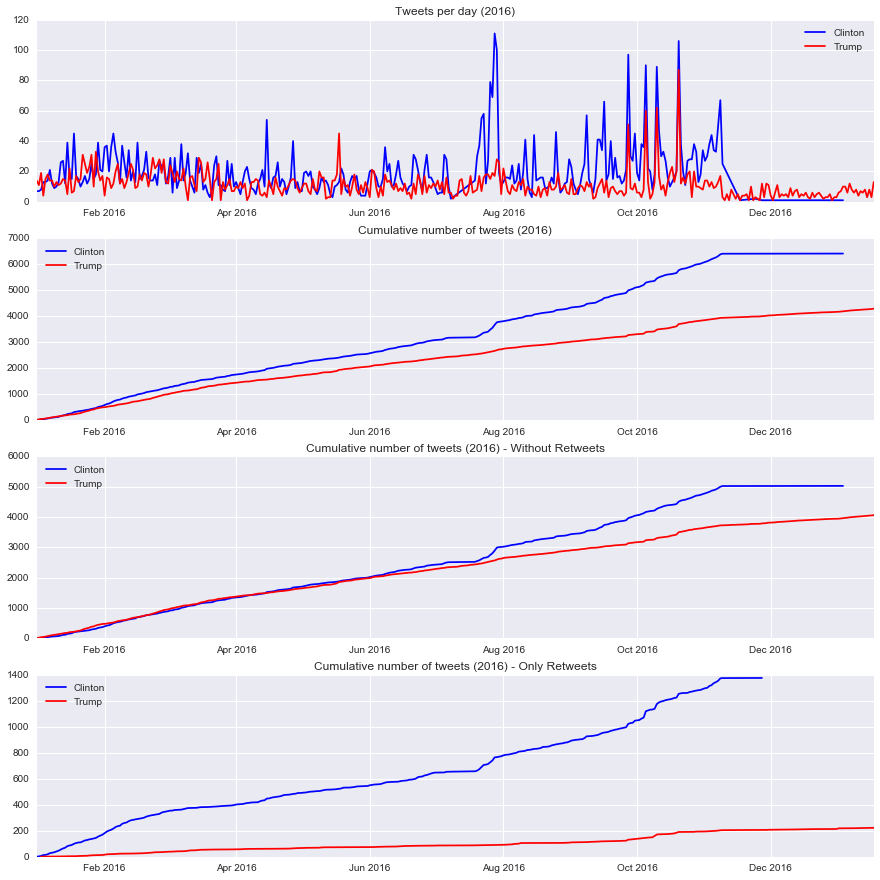

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(15,15))
plt.subplot(4, 1, 1)
pd.Series(hc_tweets_per_day).plot(title = 'Tweets per day (2016)', label = 'Clinton', color = 'b')
pd.Series(dt_tweets_per_day).plot(label = 'Trump', color = 'r')
plt.legend()

plt.subplot(4, 1, 2)
pd.Series(hc_tweets_per_day).cumsum().plot(title = 'Cumulative number of tweets (2016)', label = 'Clinton', color = 'b')
pd.Series(dt_tweets_per_day).cumsum().plot(label = 'Trump', color = 'r')
plt.legend(loc = 'upper left')

plt.subplot(4, 1, 3)
pd.Series(hc_tweets_per_day_noRT).cumsum().plot(title = 'Cumulative number of tweets (2016) - Without Retweets', label = 'Clinton', color = 'b')
pd.Series(dt_tweets_per_day_noRT).cumsum().plot(label = 'Trump', color = 'r')
plt.legend(loc = 'upper left')

plt.subplot(4, 1, 4)
pd.Series(hc_tweets_per_day_only_RT).cumsum().plot(title = 'Cumulative number of tweets (2016) - Only Retweets', label = 'Clinton', color = 'b')
pd.Series(dt_tweets_per_day_only_RT).cumsum().plot(label = 'Trump', color = 'r')
plt.legend(loc = 'upper left')
plt.show()

In [6]:
sorted_tweets_hc = [(tweets, date) for date, tweets in hc_tweets_per_day.items()]
sorted_tweets_hc.sort(reverse=True)
sorted_tweets_dt = [(tweets, date) for date, tweets in dt_tweets_per_day.items()]
sorted_tweets_dt.sort(reverse=True)

In [7]:
print 'Date of max tweets (Clinton): ' + str(sorted_tweets_hc[0][1]) + ' -- number of tweets: ' + str(sorted_tweets_hc[0][0])
print 'Date of max tweets (Trump): ' + str(sorted_tweets_dt[0][1]) + ' -- number of tweets: ' + str(sorted_tweets_dt[0][0])

Date of max tweets (Clinton): 2016-07-28 -- number of tweets: 111
Date of max tweets (Trump): 2016-10-20 -- number of tweets: 87


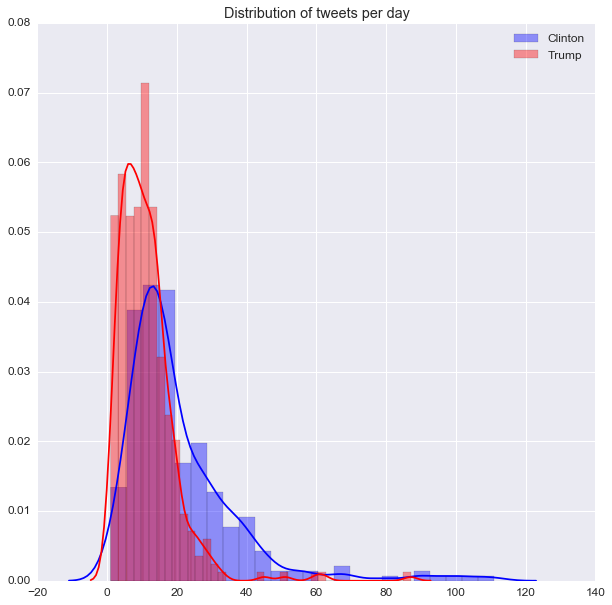

In [8]:
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    sns.distplot(hc_tweets_per_day.values(), color='b', label='Clinton')
    sns.distplot(dt_tweets_per_day.values(), color='r', label='Trump')
    plt.title("Distribution of tweets per day")
    plt.legend()
plt.show()

Trump's tweets per day are less frequent, with a distribution heavily skewed towards the low end. 

## 3. Hashtag frequency Trump/Clinton  (2016) - (Simple demo of NLTK usage.)

In [9]:
#Import modules. We'll use the tweeter tokenizer

import nltk
from nltk.tokenize import TweetTokenizer

In [10]:
#Extract tweets from 2016 - Create mask for dataframe

dt_mask_2016 = ((df_dt.created_at >= datetime.datetime.strptime('2016-01-01',"%Y-%m-%d")) & (df_dt.created_at < datetime.datetime.strptime('2017-01-01',"%Y-%m-%d")))
hc_mask_2016 = ((df_hc.created_at >= datetime.datetime.strptime('2016-01-01',"%Y-%m-%d")) & (df_hc.created_at < datetime.datetime.strptime('2017-01-01',"%Y-%m-%d")))

In [11]:
#Use tokenizer to extract hashtags:

tknzr = TweetTokenizer()
dt_hastags = Counter([y.lower() for x in df_dt[dt_mask_2016].text for y in tknzr.tokenize(x) if (y[0] =='#' and len(y)>1)]) 
hc_hastags = Counter([y.lower() for x in df_hc[hc_mask_2016].text for y in tknzr.tokenize(x) if (y[0] =='#' and len(y)>1)]) 

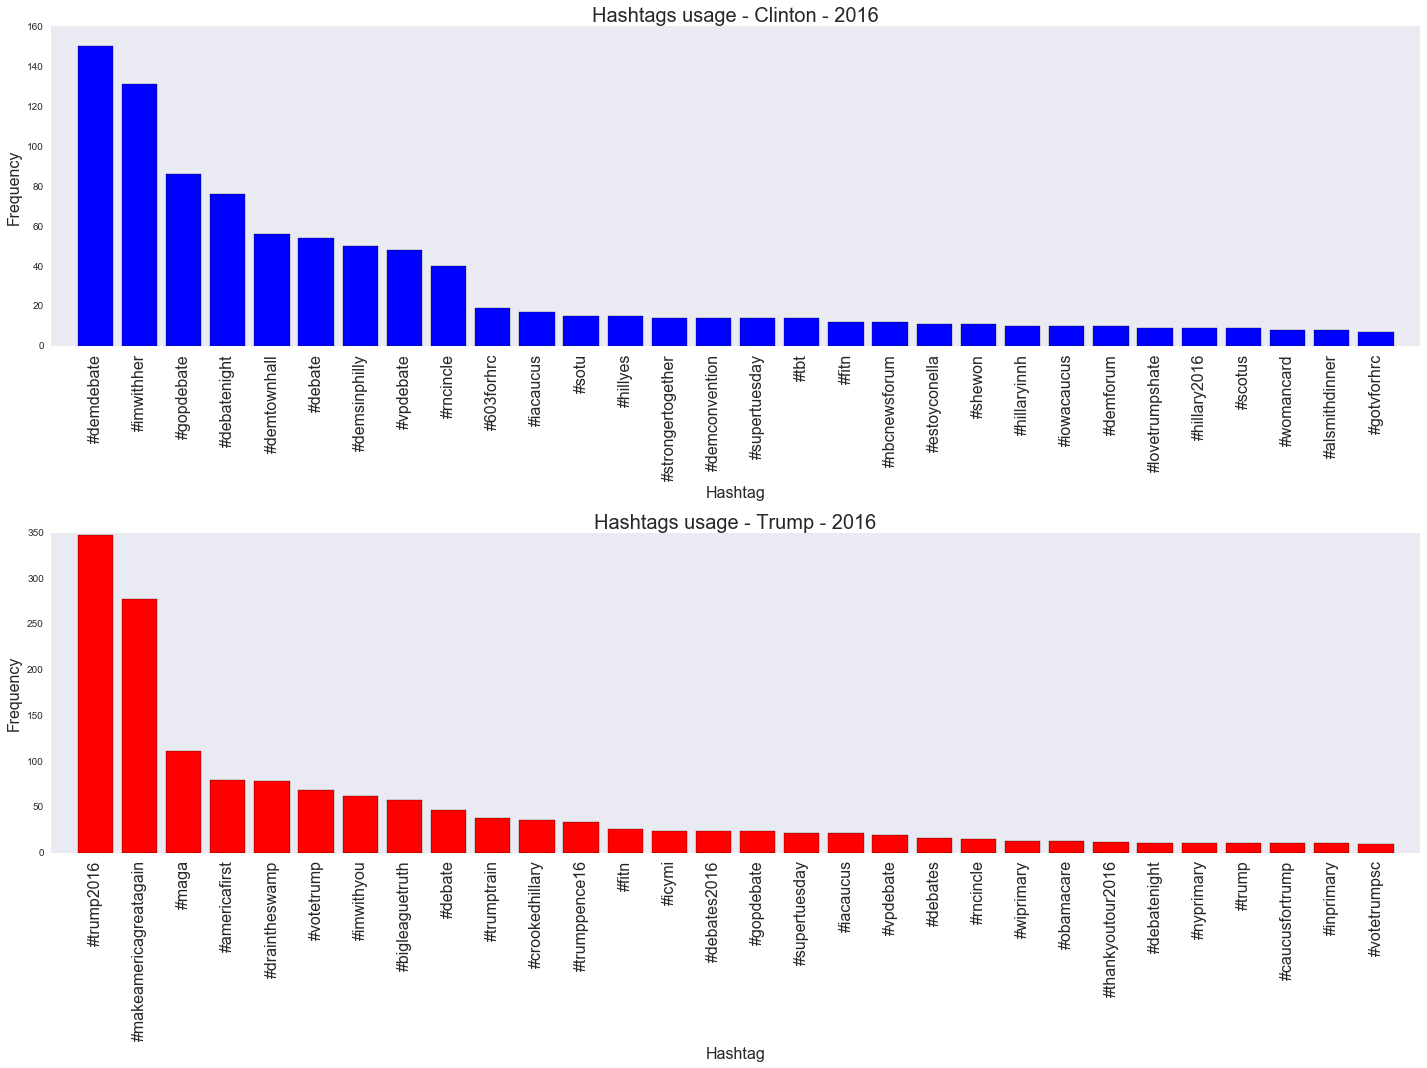

In [12]:
#Barplot of hashtags.

#plt.style.use('ggplot')
n_hast = 30
fig, axes = plt.subplots(2,1, figsize=(20,15))
axes[0].bar(range(n_hast), [x[1] for x in hc_hastags.most_common(n_hast)], width=0.8, align = 'center', color = 'b')
axes[0].set_xlabel('Hashtag', fontsize = 16)
axes[0].set_ylabel('Frequency', fontsize = 16)
axes[0].set_title(r'Hashtags usage - Clinton - 2016', fontsize = 20)
axes[0].set_xticks(range(n_hast))
axes[0].set_xticklabels([x[0] for x in hc_hastags.most_common(n_hast)], rotation = 90, fontsize = 16)
axes[0].set_xlim(left=-1)
plt.tight_layout()
axes[0].grid(False)
#axes[0].tight_layout()

axes[1].bar(range(n_hast), [x[1] for x in dt_hastags.most_common(n_hast)], width=0.8, align = 'center', color = 'r')
axes[1].set_xlabel('Hashtag', fontsize = 16)
axes[1].set_ylabel('Frequency', fontsize = 16)
axes[1].set_title(r'Hashtags usage - Trump - 2016', fontsize = 20)
axes[1].set_xticks(range(n_hast))
axes[1].set_xticklabels([x[0] for x in dt_hastags.most_common(n_hast)], rotation = 90, fontsize = 16)
axes[1].set_xlim(left=-1)
plt.tight_layout()
axes[1].grid(False)

plt.show()

## 4. Words used in tweets for either candidate - histogram

Again, use the tokenizer of the very good NLTK module:

In [13]:
#Use tokenizer to extract hashtags:

tknzr = TweetTokenizer()
dt_words = Counter([y.lower() for x in df_dt[dt_mask_2016].text for y in tknzr.tokenize(x) if (len(y)>1)]) 
hc_words = Counter([y.lower() for x in df_hc[hc_mask_2016].text for y in tknzr.tokenize(x) if (len(y)>1)]) 

In [14]:
dt_words.most_common(10) #Sample before filtering:

[(u'the', 2338),
 (u'to', 1505),
 (u'in', 1202),
 (u'and', 1200),
 (u'is', 1000),
 (u'you', 996),
 (u'of', 985),
 (u'will', 807),
 (u'for', 764),
 (u'on', 748)]

Not very good, lots of stop words and links, retweets, etc. This needs cleaning

In [15]:
#Import module for stopwords
from nltk.corpus import stopwords

In [77]:
def cleanupDoc(tweet, onlytext = False):
    stopset = set(stopwords.words('english'))
    tokens = tknzr.tokenize(tweet) #use the twitter tokenizer
    cleanup = [token.lower() for token in tokens if token.lower() not in stopset and token.lower() != '...' and len(token)>2]
    cleanup2 = []
    for x in cleanup:
        if 'http' in x:
            x = 'LINK'
        elif '@' in x:
            x = 'RT'
        elif '#' in x:
            x = 'HASHTAG'
        else:
            pass
        if onlytext == True:
            if x not in ['LINK', 'RT', 'HASHTAG']:
                cleanup2.append(x)
        else:
            cleanup2.append(x)
    return cleanup2

In [80]:
dt_tweets_2016 = [x for x in df_dt[dt_mask_2016].text]
temp = []
for tweet in dt_tweets_2016:
    temp.extend(cleanupDoc(tweet, onlytext=False))
dt_tweets_count_2016 = Counter(temp)

In [81]:
dt_tweets_count_2016.most_common(20)

[('RT', 2580),
 ('LINK', 2090),
 ('HASHTAG', 2015),
 (u'thank', 641),
 (u'great', 578),
 (u'hillary', 460),
 (u'trump', 423),
 (u'clinton', 281),
 (u'people', 278),
 (u'america', 265),
 (u'new', 238),
 (u'crooked', 231),
 (u'make', 220),
 (u'get', 198),
 (u'cruz', 195),
 (u'vote', 180),
 (u'join', 177),
 (u'big', 164),
 (u'today', 146),
 (u'president', 143)]

In [19]:
hc_tweets_2016 = [x for x in df_hc[hc_mask_2016].text]
temp = []
for tweet in hc_tweets_2016:
    temp.extend(cleanupDoc(tweet))
hc_tweets_count_2016 = Counter(temp)

In [20]:
hc_tweets_count_2016.most_common(20)

[('LINK', 5119),
 ('RT', 3238),
 (u'hillary', 1488),
 ('HASHTAG', 1410),
 (u'trump', 1123),
 (u'donald', 601),
 (u'president', 545),
 (u'make', 412),
 (u'america', 365),
 (u'vote', 339),
 (u'one', 335),
 (u'people', 334),
 (u'need', 317),
 (u'women', 270),
 (u'families', 258),
 (u'get', 252),
 (u"it's", 229),
 (u'country', 223),
 (u'clinton', 220),
 (u'americans', 217)]

With this clean, tokenized version of the tweets, we get bar diagrams to check the most commonly used words by each:

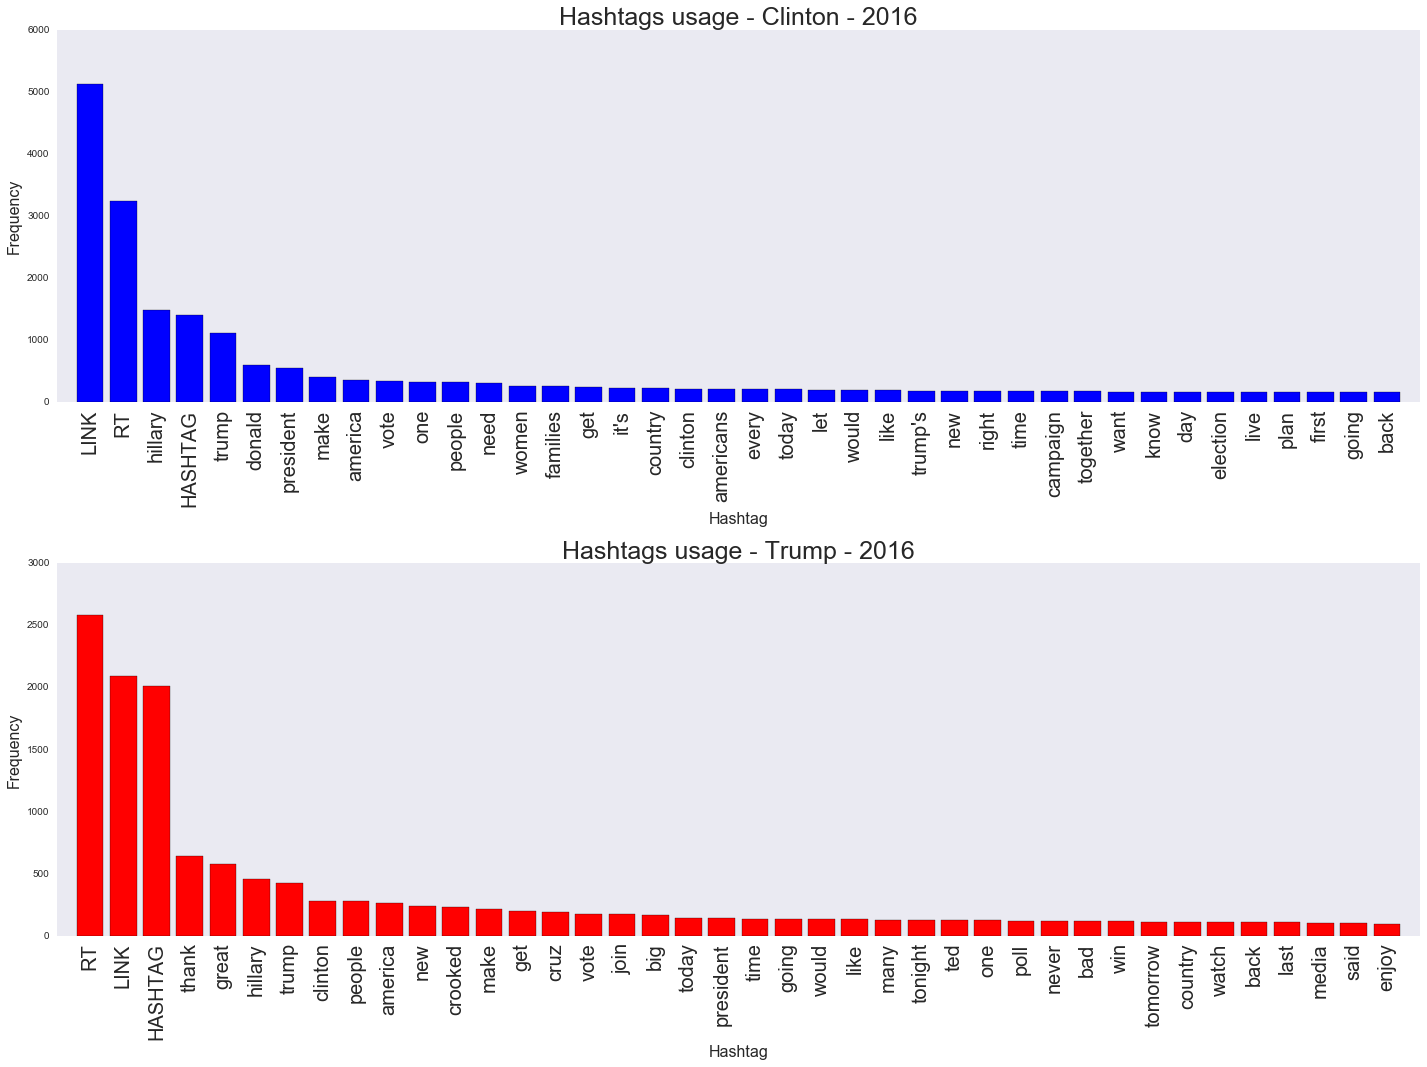

In [21]:
#Barplot of hashtags.

#plt.style.use('ggplot')
w_num = 40
fig, axes = plt.subplots(2,1, figsize=(20,15))
axes[0].bar(range(w_num), [x[1] for x in hc_tweets_count_2016.most_common(w_num)], width=0.8, align = 'center', color = 'b')
axes[0].set_xlabel('Hashtag', fontsize = 16)
axes[0].set_ylabel('Frequency', fontsize = 16)
axes[0].set_title(r'Hashtags usage - Clinton - 2016', fontsize = 25)
axes[0].set_xticks(range(w_num))
axes[0].set_xticklabels([x[0] for x in hc_tweets_count_2016.most_common(w_num)], rotation = 90, fontsize = 20)
axes[0].set_xlim(left=-1)
plt.tight_layout()
axes[0].grid(False)
#axes[0].tight_layout()

axes[1].bar(range(w_num), [x[1] for x in dt_tweets_count_2016.most_common(w_num)], width=0.8, align = 'center', color = 'r')
axes[1].set_xlabel('Hashtag', fontsize = 16)
axes[1].set_ylabel('Frequency', fontsize = 16)
axes[1].set_title(r'Hashtags usage - Trump - 2016', fontsize = 25)
axes[1].set_xticks(range(w_num))
axes[1].set_xticklabels([x[0] for x in dt_tweets_count_2016.most_common(w_num)], rotation = 90, fontsize = 20)
axes[1].set_xlim(left=-1)
plt.tight_layout()
axes[1].grid(False)

plt.show()

In [22]:
#Testing a porter stemmer... doesn't seem to work great here

from nltk.stem.porter import *

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

stemmer = PorterStemmer()
stemmed = stem_tokens(hc_tweets_count_2016.keys()[:20], stemmer)
count = Counter(stemmed)
print count.most_common(20)

[(u'aggress', 1), (u'fuera', 1), (u'elig', 1), (u'march', 1), (u'look', 1), (u'tire', 1), (u'woodi', 1), (u'four-year', 1), (u'rail', 1), (u'wednesday', 1), (u'igual', 1), (u'four', 1), (u'bring', 1), (u'lori', 1), (u'puls', 1), (u'waver', 1), (u'politician', 1), (u'broward', 1), (u'caryn', 1), (u'prize', 1)]


##  5. Predictive model. If we use a machine learning model, how certain are we of the author of the tweet?

In [23]:
#Import machine learning models
import numpy as np

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, grid_search
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import SGDClassifier

/Users/carlosjarguello/anaconda/envs/insight_project/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/carlosjarguello/anaconda/envs/insight_project/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [24]:
#How many unique words per candidate?
print 'Clinton unique words: ' + str(len(hc_tweets_count_2016.keys()))
print 'Trump unique words: ' + str(len(dt_tweets_count_2016.keys()))

Clinton unique words: 7497
Trump unique words: 5906


In [25]:
#How many tweets do we have per person?
print 'clinton tweets= ' + str(len(hc_tweets_2016)) + ' trump tweets= ' + str(len(dt_tweets_2016))

clinton tweets= 6406 trump tweets= 4162


In [26]:
np.random.shuffle(hc_tweets_2016)
np.random.shuffle(dt_tweets_2016)

In [27]:
#Vectorizer for going from words -> numbers
vectorizer = TfidfVectorizer(tokenizer=cleanupDoc, min_df=5,
                                 max_df = 0.8,
                                 sublinear_tf=True,
                                 use_idf=True)

In [28]:
#Pick subset of data to train a predictive model with Trump/Clinton classes
clinton_train = hc_tweets_2016[:3200]; trump_train = dt_tweets_2016[:2100]

In [29]:
X_train = vectorizer.fit_transform(clinton_train+trump_train);
y_train = ['Clinton' for _ in range(len(clinton_train))] + ['Trump' for _ in range(len(trump_train))]

In [30]:
#Are we overfitting? - Maybe:
X_train.shape

(5300, 1674)

In [31]:
#Choose SVM/linear kernel as classifier
clf_linear = svm.SVC(kernel='linear')

In [32]:
clf_linear.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
#Define validation set
trump_val = dt_tweets_2016[2100:3000]; clinton_val = hc_tweets_2016[3200:4200];
y_val = ['Clinton' for _ in range(len(clinton_val))] + ['Trump' for _ in range(len(trump_val))]

In [34]:
pr_linear_val = clf_linear.predict(vectorizer.transform(clinton_val+trump_val))

In [35]:
#Evaluate predictive power in validating set
print classification_report(y_val, pr_linear_val)

             precision    recall  f1-score   support

    Clinton       0.83      0.93      0.88      1000
      Trump       0.91      0.79      0.85       900

avg / total       0.87      0.86      0.86      1900



Good predictive power! Let's check on the test set:

In [36]:
#Define test set for classifier
trump_test = dt_tweets_2016[3000:]; clinton_test = hc_tweets_2016[4200:]
y_test = ['Clinton' for _ in range(len(clinton_test))] + ['Trump' for _ in range(len(trump_test))]

In [37]:
pr_linear_test = clf_linear.predict(vectorizer.transform(clinton_test+trump_test))

In [38]:
#Evaluate predictive power in test set
print classification_report(y_test, pr_linear_test)

             precision    recall  f1-score   support

    Clinton       0.88      0.92      0.90      2206
      Trump       0.83      0.77      0.80      1162

avg / total       0.87      0.87      0.87      3368



Not bad!!! We're not overfitting...

### Now the fun part... We saw Clinton's/Trump's hashtags/words. The model is (reasonably) successful in predicting tweets authored by each candidate. What are the most relevant features to define a given class? (i.e., what does a tweet have to say to be more "Clintoney" or "Trumpey"?

In [39]:
#Function to extract most important features from classifier (by coeficient value)
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_list = np.array(clf.coef_.todense()).flatten()
    coefs_with_fns = sorted(zip(coefs_list, feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)

### And... Clinton vs Trump speech (as classified by the model)

In [40]:
show_most_informative_features(vectorizer, clf_linear, 30)

	-3.5145	LINK           		4.4064	crooked        
	-2.7705	hillary        		3.4456	great          
	-2.3109	donald         		2.9246	media          
	-2.1739	volunteers     		2.7209	thank          
	-2.0960	barack         		2.6867	rubio          
	-1.8520	climate        		2.6339	cruz           
	-1.8029	gun            		2.5514	wow            
	-1.7923	fighting       		2.5469	HASHTAG        
	-1.6254	here's         		2.3573	cnn            
	-1.6184	flint          		2.0626	video          
	-1.6106	families       		2.0620	jeb            
	-1.5809	afford         		2.0515	poll           
	-1.5748	start          		1.9647	unbelievable   
	-1.5153	excited        		1.9555	via            
	-1.5140	discrimination 		1.9543	speech         
	-1.5031	couldn't       		1.9359	border         
	-1.4792	chip           		1.9113	clinton        
	-1.4648	americans      		1.8665	pope           
	-1.4525	lgbt           		1.8380	interesting    
	-1.4347	weight         		1.8040	allowed        
	-1.4191	kids       

Can we improve the classifier? (Gridsearch)

In [41]:
param_grid_svc = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svr = svm.SVC()

In [ ]:
clf = grid_search.GridSearchCV(estimator = svr, param_grid = param_grid_svc, cv = 3)
V_data = vectorizer.transform(hc_tweets_2016+dt_tweets_2016)
y_label = ['Clinton' for _ in range(len(hc_tweets_2016))] + ['Trump' for _ in range(len(dt_tweets_2016))]
clf.fit(V_data, y_label)

In [ ]:
clf.best_score_

## 6. Using Latent Dirichlet Allocation: Can we find 5 different topics by politician?

In [67]:
import gensim
from gensim import corpora, models

To generate an LDA model, we need to understand how frequently each term occurs within each document. To do that, we need to construct a document-term matrix with a package called gensim:

In [51]:
hc_tweets_2016[0]

u'Trump on Alicia, 1996: "Miss Piggy."\n\nThis morning: "She gained a massive amount of weight...it was a real problem." https://t.co/0wrISjJe6z'

In [82]:
dictionary_hc = corpora.Dictionary([cleanupDoc(x, onlytext=True) for x in hc_tweets_2016])
dictionary_dt = corpora.Dictionary([cleanupDoc(x, onlytext=True) for x in dt_tweets_2016])

The Dictionary() function traverses texts, assigning a unique integer id to each unique token while also collecting word counts and relevant statistics. To see each token’s unique integer id, try print(dictionary.token2id).

In [83]:
#convert to bag-of-words:
corpus_hc = [dictionary_hc.doc2bow(text) for text in [cleanupDoc(x, onlytext=True) for x in hc_tweets_2016]]
corpus_dt = [dictionary_dt.doc2bow(text) for text in [cleanupDoc(x, onlytext=True) for x in dt_tweets_2016]]

This list of tuples represents our first document, doc_a. The tuples are (term ID, term frequency) pairs, so if print(dictionary.token2id) says brocolli’s id is 0, then the first tuple indicates that brocolli appeared twice in doc_a. doc2bow() only includes terms that actually occur: terms that do not occur in a document will not appear in that document’s vector.

In [90]:
#Fitting model
ldamodel_hc = gensim.models.ldamodel.LdaModel(corpus_hc, num_topics=3, id2word = dictionary_hc, passes=30)

In [91]:
#Fitting model
ldamodel_dt = gensim.models.ldamodel.LdaModel(corpus_dt, num_topics=3, id2word = dictionary_dt, passes=30)

Once the model is fitted, let's see if we can distinguish some topics:

In [98]:
ldamodel_hc.print_topics(num_topics=3, num_words=25)

[(0,
  u'0.030*"hillary" + 0.012*"vote" + 0.012*"make" + 0.008*"need" + 0.008*"families" + 0.007*"every" + 0.007*"today" + 0.006*"rights" + 0.006*"back" + 0.006*"day" + 0.006*"get" + 0.006*"together" + 0.006*"right" + 0.006*"america" + 0.006*"help" + 0.006*"it\'s" + 0.005*"one" + 0.005*"live" + 0.005*"americans" + 0.005*"let\'s" + 0.005*"let" + 0.005*"president" + 0.005*"people" + 0.005*"time" + 0.005*"election"'),
 (1,
  u'0.016*"hillary" + 0.008*"trump" + 0.007*"new" + 0.007*"fighting" + 0.006*"los" + 0.006*"que" + 0.005*"paid" + 0.005*"family" + 0.005*"call" + 0.005*"york" + 0.004*"pay" + 0.004*"para" + 0.004*"leave" + 0.004*"kids" + 0.004*"las" + 0.004*"thank" + 0.004*"watch" + 0.004*"women" + 0.003*"una" + 0.003*"care" + 0.003*"life" + 0.003*"law" + 0.003*"we\'re" + 0.003*"equal" + 0.003*"tonight\'s"'),
 (2,
  u'0.041*"trump" + 0.024*"donald" + 0.021*"hillary" + 0.017*"president" + 0.008*"trump\'s" + 0.007*"america" + 0.007*"one" + 0.007*"people" + 0.006*"would" + 0.006*"clinton" 

In [99]:
ldamodel_dt.print_topics(num_topics=3, num_words=25)

[(0,
  u'0.053*"thank" + 0.039*"great" + 0.016*"america" + 0.015*"ohio" + 0.015*"make" + 0.014*"vote" + 0.011*"big" + 0.010*"join" + 0.009*"tomorrow" + 0.009*"trump" + 0.008*"new" + 0.007*"morning" + 0.007*"michigan" + 0.007*"kansas" + 0.007*"amazing" + 0.007*"today" + 0.007*"tonight" + 0.007*"people" + 0.006*"carolina" + 0.006*"rally" + 0.006*"florida" + 0.006*"enjoy" + 0.006*"crowd" + 0.005*"support" + 0.005*"remember"'),
 (1,
  u'0.011*"trump" + 0.009*"people" + 0.008*"many" + 0.008*"jobs" + 0.007*"kasich" + 0.007*"candidate" + 0.007*"presidential" + 0.006*"like" + 0.006*"win" + 0.006*"failed" + 0.006*"get" + 0.006*"back" + 0.006*"president" + 0.005*"would" + 0.005*"republican" + 0.005*"america" + 0.005*"new" + 0.004*"romney" + 0.004*"debate" + 0.004*"got" + 0.004*"donald" + 0.004*"lost" + 0.004*"states" + 0.004*"cruz" + 0.004*"two"'),
 (2,
  u'0.021*"hillary" + 0.013*"clinton" + 0.012*"trump" + 0.011*"crooked" + 0.009*"people" + 0.007*"dishonest" + 0.007*"one" + 0.006*"media" + 0.0

"This explanation is a little lengthy, but useful for understanding the model we worked so hard to generate.

LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution, like the ones in our walkthrough model. In other words, LDA assumes a document is made from the following steps:

Determine the number of words in a document. Let’s say our document has 6 words.
Determine the mixture of topics in that document. For example, the document might contain 1/2 the topic “health” and 1/2 the topic “vegetables.”
Using each topic’s multinomial distribution, output words to fill the document’s word slots. In our example, the “health” topic is 1/2 our document, or 3 words. The “health” topic might have the word “diet” at 20% probability or “exercise” at 15%, so it will fill the document word slots based on those probabilities.
Given this assumption of how documents are created, LDA backtracks and tries to figure out what topics would create those documents in the first place."